# Prepare test  satellite images 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

It is recommended that the final polymer products should be filtered with bitmask & 1023 (111111111), which means filtering out the flags:
- LAND
- CLOUD_BASE
- L1_INVALID
- NEGATIVE_BB
- OUT_OF_BOUNDS
- EXCEPTION
- THICK_AEROSOL
- HIGH_AIR_MASS
- EXTERNAL_MASS.


From READM.md
  
| Flag name          | Flag value  | Description                                |
|--------------------|-------------|--------------------------------------------|
| LAND               | 1           | Land mask                                  |
| CLOUD_BASE         | 2           | Polymer's basic cloud mask                 |
| L1_INVALID         | 4           | Invalid level1 pixel                       |
| NEGATIVE_BB        | 8           | (deprecated flag)                          |
| OUT_OF_BOUNDS      | 16          | Retrieved marine parameters are outside    |
|                    |             | valid bounds                               |
| EXCEPTION          | 32          | A processing error was encountered         |
| THICK_AEROSOL      | 64          | Thick aerosol flag                         |
| HIGH_AIR_MASS      | 128         | Air mass exceeds 5                         |
| EXTERNAL_MASK      | 512         | Pixel was masked using external mask       |
| CASE2              | 1024        | Pixel was processed in "case2" mode        |
| INCONSISTENCY      | 2048        | Inconsistent result was detected           |
|                    |             | (atmospheric reflectance out of bounds     |
| ANOMALY_RWMOD_BLUE | 4096        | Excessive difference was found at 412nm    |
|                    |             | between Rw and Rwmod                       |



| Sensor   | Recommended flagging (valid pixels) | Notes                     |
|----------|------------------------------|----------------------------------|
| OLCI     | bitmask & 1023 == 0          |                                  |
|          |                              |                                  |
| MSI      | bitmask & 1023 == 0          |                                  |
|          |                              |                                  |
| MERIS    | bitmask & 1023 == 0          |                                  |
|          |                              |                                  |
| VIIRS    | bitmask & 1023 == 0          | Sun glint and bright (cloudy)    |
|          | and (Rnir<0.1)               | pixels are discarded             |
|          | and (Rgli<0.1)               |                                  |
|          |                              |                                  |
| SeaWiFS  | bitmask & 1023+2048 == 0     | The INCONSISTENCY flag           |
|          |                              | cleans up most noisy pixels      |
|          |                              |                                  |
| MODIS    | bitmask & 1023+4096 == 0     | The ANOMALY_RWMOD_BLUE removes   |
|          |                              | outliers appearing on MODIS      |
|          |                              | results at high SZA              |

Note: additional cloud masking using IdePix (https://github.com/bcdev/snap-idepix) is recommended.



In [17]:
#polymerfile='Documents/temp/ForelUle/S3A_OL_1_EFR____20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.SEN3.nc'
#polymersmallfile='data/S3A_OL_20200506T104005_20200506T104305_20200507T143731_0179_058_051_1980_LN1_O_NT_002.polymer.LivBay.nc'

# EngWales
#polymerfile='Documents/temp/ForelUle/S3A_OL_1_EFR____20200203T105112_20200203T105412_20200204T152758_0179_054_265_1980_LN1_O_NT_002.polymer.nc'
#polymersmallfile='data/S3A_OL_1_EFR____20200203T105112_20200203T105412_20200204T152758_0179_054_265_1980_LN1_O_NT_002.polymer.thewash.nc'

# Restrict to Liverpool Bay
#height=slice(3200,3400)
#width=slice(2400,2650))

# Restrict to The Wash
#height = slice(2900,3150)
#width=slice(4000,4400)

# Venbanad Lake and Bhitarkanika National Park
#polymerfile='Documents/temp/ForelUle/S3B_OL_1_EFR____20200112T045045_20200112T045345_20200113T085230_0179_034_190_2700_LN1_O_NT_002.polymer.nc'
#polymersmallfile=r'C:\Users\tams00\OneDrive - CEFAS\git\FUME\data\S3B_OL_1_EFR____20200112T045045_20200112T045345_20200113T085230_0179_034_190_2700_LN1_O_NT_002.polymer.venbanad_lake.nc'
#height = slice(3600,4100)
#width = slice(2700,3100)

# Chilika Lake
polymerfile='Documents/temp/ForelUle/S3B_OL_1_EFR____20200109T042519_20200109T042819_20200114T040052_0179_034_147_2520_MAR_O_NT_002.polymer.nc'
polymersmallfile=r'C:\Users\tams00\OneDrive - CEFAS\git\FUME\data\S3B_OL_1_EFR____20200109T042519_20200109T042819_20200114T040052_0179_034_147_2520_MAR_O_NT_002.polymer.chilika_lake.nc'
height=slice(3300,4500)
width=slice(3250,4250)

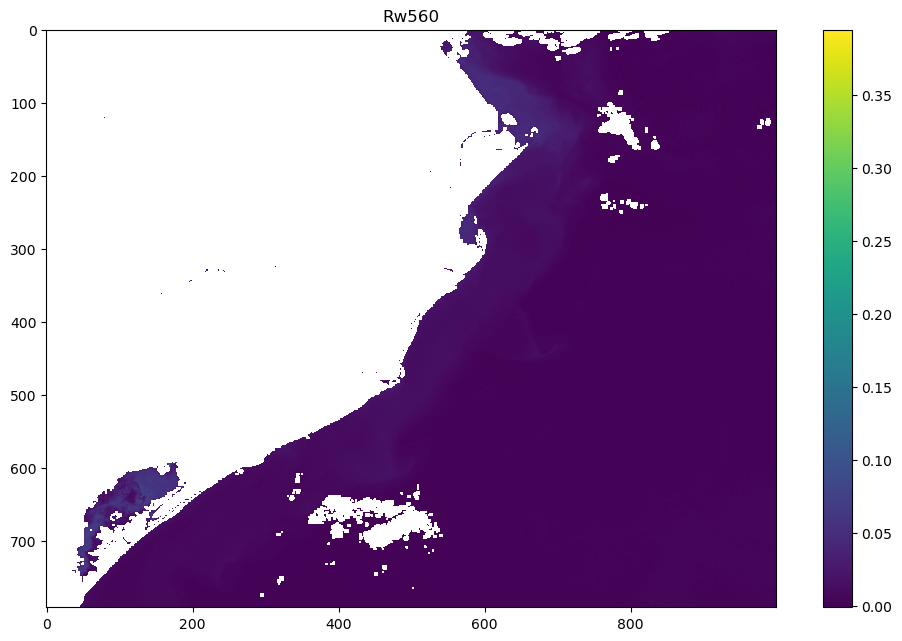

In [18]:
# prepare test dataset
polymer = xr.open_dataset(
    Path.home() / 
    Path(polymerfile))

# Restrict to Liverpool Bay
#polymer = polymer.isel(height=

polymer = polymer.isel(height=height,width=width)
    
# Swir bands not useful for water classification
polymer = polymer.drop(['Rnir','Rgli','logchl','bbs','Rw865','Rw1020'])

#plt.imshow(polymer['Rw665'],vmax=polymer['Rw665'].quantile(0.95))
fig=plt.figure(figsize=(12,7.5))
plt.imshow(polymer['Rw560'])
plt.title('Rw560')
plt.colorbar()

#Save to new netcdf file 
polymer.to_netcdf(polymersmallfile)

### Plot surface reflectance Rrs

C:\Users\tams00\AppData\Local\mambaforge\envs\FUME\Lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\tams00\AppData\Local\mambaforge\envs\FUME\Lib\site-packages\xarray\core\computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


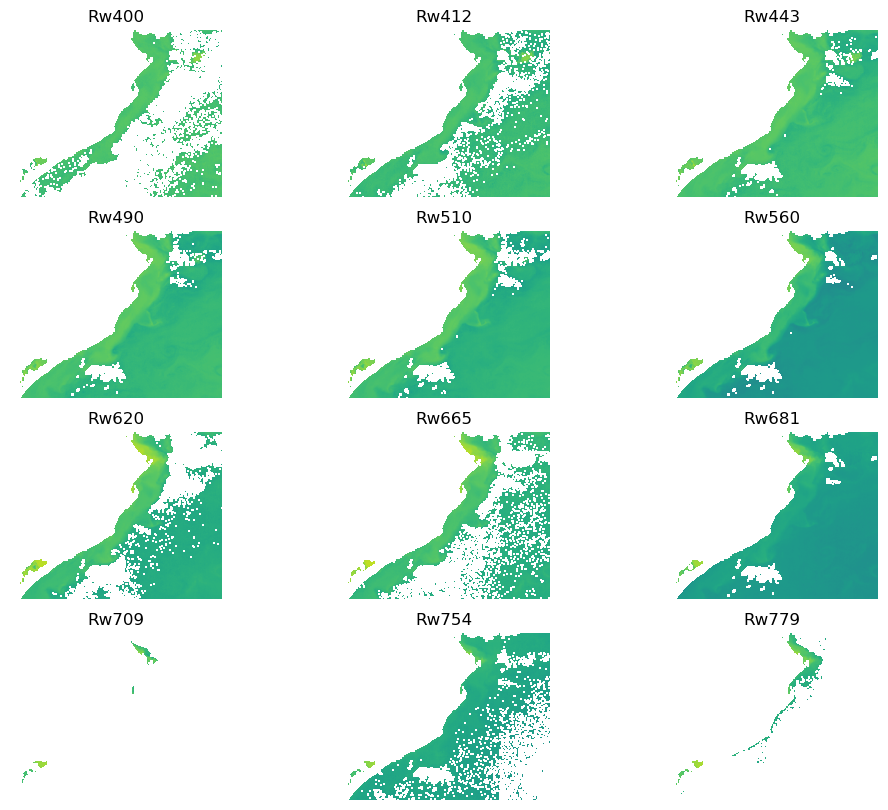

In [19]:
bands = [var for var in list( polymer.data_vars ) if 'Rw' in var]
fig,axs = plt.subplots(nrows=4,ncols=3,figsize=(12,10))
axs= axs.flatten()

for iband,band in enumerate(bands):
    axs[iband].imshow(np.log(polymer[band]))
    axs[iband].set_title(band)
    axs[iband].set_axis_off()

## Parse and plot quality flags

In [20]:
polymer = xr.open_dataset(
    Path(polymersmallfile))

bitmask = polymer['bitmask'].astype('int')

print(bitmask.attrs)

flagstext=polymer['bitmask'].attrs['description'].split(',')
flags = [text.split(':') for text in flagstext]
flags = [[flag[0].strip(),int(flag[1])] for flag in flags]
flags


{'description': 'LAND:1, CLOUD_BASE:2, L1_INVALID:4, NEGATIVE_BB:8, OUT_OF_BOUNDS:16, EXCEPTION:32, THICK_AEROSOL:64, HIGH_AIR_MASS:128, EXTERNAL_MASK:512, CASE2:1024, INCONSISTENCY:2048, ANOMALY_RWMOD_BLUE:4096', 'bitmask_reject': 'bitmask & 1023 != 0'}


[['LAND', 1],
 ['CLOUD_BASE', 2],
 ['L1_INVALID', 4],
 ['NEGATIVE_BB', 8],
 ['OUT_OF_BOUNDS', 16],
 ['EXCEPTION', 32],
 ['THICK_AEROSOL', 64],
 ['HIGH_AIR_MASS', 128],
 ['EXTERNAL_MASK', 512],
 ['CASE2', 1024],
 ['INCONSISTENCY', 2048],
 ['ANOMALY_RWMOD_BLUE', 4096]]

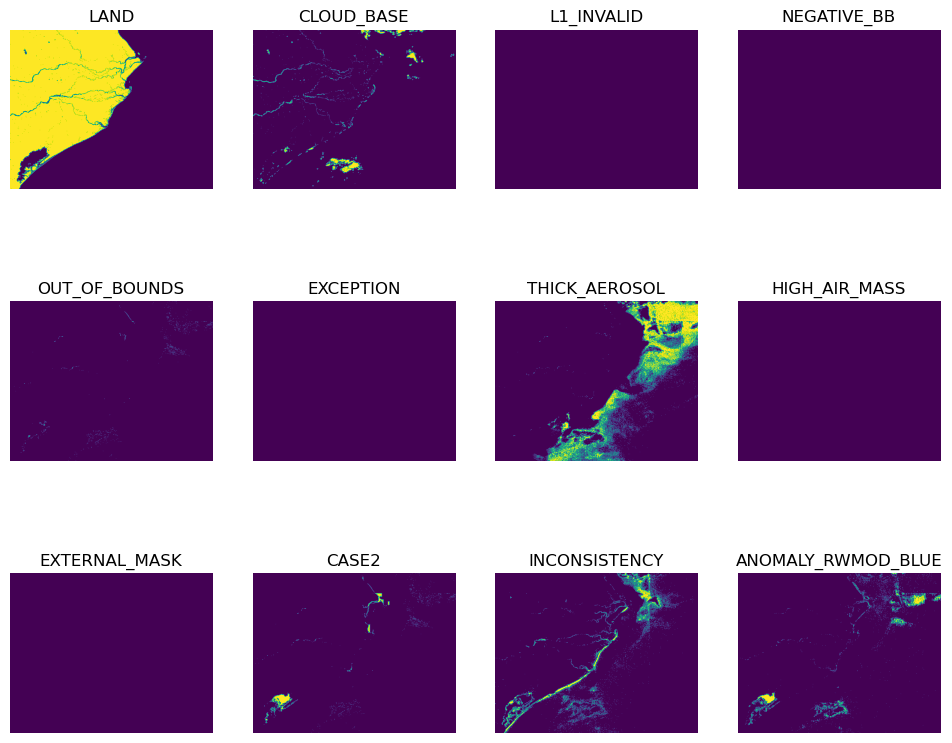

In [21]:
fig,axs = plt.subplots(nrows=3,ncols=4,figsize=(12,10))
axs= axs.flatten()
for iflag,flag in enumerate(flags):
    axs[iflag].imshow( bitmask & flag[1])
    axs[iflag].set_title(flag[0])
    axs[iflag].set_axis_off()

## Map all flags

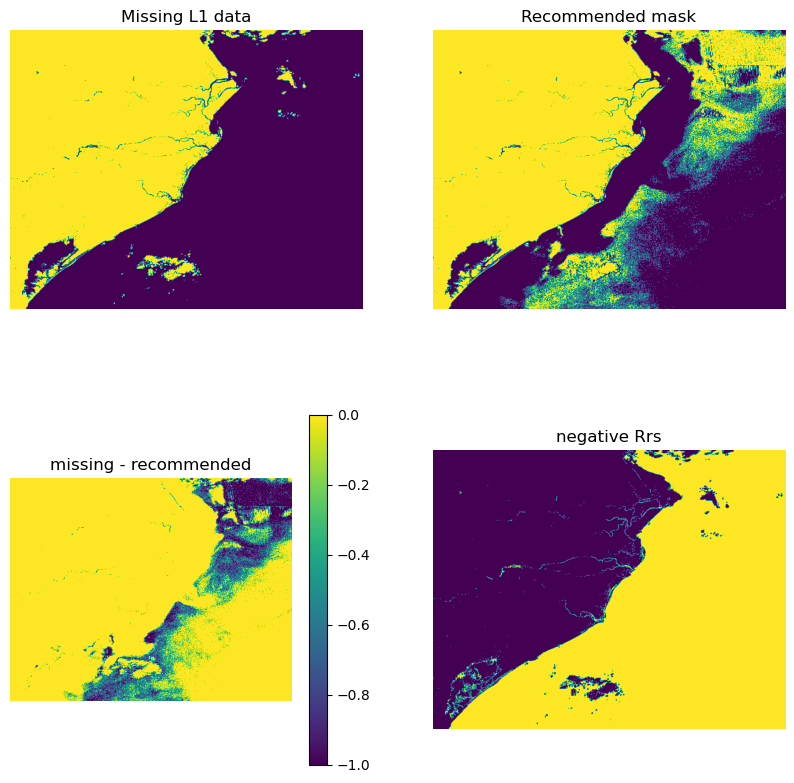

In [24]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
axs= axs.flatten()

stacked = polymer[bands].to_stacked_array('bands',sample_dims=('height','width'))
missingl1 = np.any( np.isnan(stacked.values), axis=2)
m = axs[0].imshow( missingl1 )
axs[0].set_title('Missing L1 data')
axs[0].set_axis_off()

mask = (bitmask & 1023)>0
m = axs[1].imshow( mask )
axs[1].set_title('Recommended mask')
axs[1].set_axis_off()

m = axs[2].imshow( missingl1 - mask.astype('int') )
axs[2].set_title('missing - recommended')
axs[2].set_axis_off()
plt.colorbar(mappable=m)


negativerrs = np.any(stacked<0, axis=2)
m = axs[3].imshow( negativerrs )
axs[3].set_title('negative Rrs')
axs[3].set_axis_off()



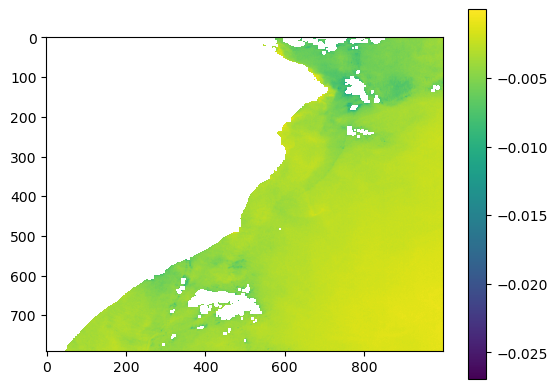

In [32]:
plt.imshow( xr.where( polymer['Rw709']<0, polymer['Rw709'], float('nan') ))
plt.colorbar()

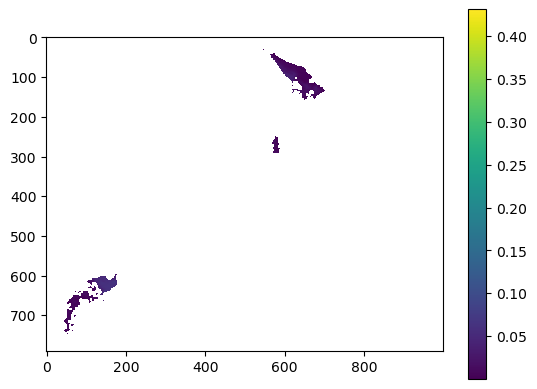

In [34]:
plt.imshow( xr.where( polymer['Rw709']>=0, polymer['Rw709'], float('nan') ))
plt.colorbar()